# Can luminosity distribution explain FRB flux distribution?

## First, model luminosity distribution

In [326]:
%matplotlib inline

In [344]:
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
import astropy.cosmology as cosmo
import astropy.units as u

In [328]:
# reference values and functions
lum_s = lambda ld, s: s*1e-23 * (4*np.pi*ld**2) * 5e-3 * 1.024e9 # lum in erg, s in Jy, ld in cm

co = cosmo.Planck15
ld0 = co.luminosity_distance(0.193)

lum = np.array([1.5, 12, 0.6, 0.4, 2.1, 0.2, 0.4, 0.6, 0.6])* 1e39
lum.sort()

Powerlaw slope -0.559492842533 and amplitude 9.68028817665 (at L=2e+38)


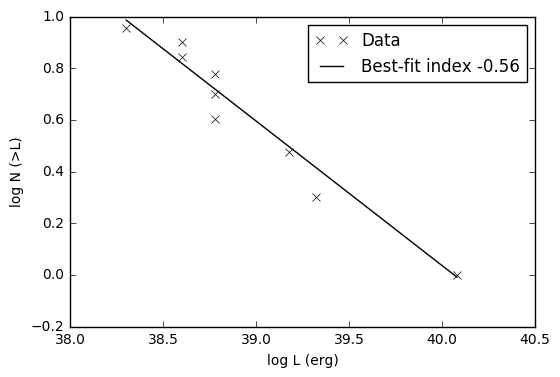

In [329]:
# fit and plot
cnt = np.arange(1,len(lum)+1)[::-1]
plaw = lambda ll, alpha, a: a*(ll/ll[0])**alpha
popt, pcov = curve_fit(plaw, lum, cnt, p0=(-1, 10))
print('Powerlaw slope {0} and amplitude {1} (at L={2})'.format(popt[0], popt[1], lum[0]))

pl.plot(np.log10(lum), np.log10(cnt), 'kx', label='Data')
pl.plot(np.log10(lum), np.log10(plaw(lum, *popt)), '-k', label='Best-fit index {0:.2f}'.format(popt[0]))
pl.xlabel('log L (erg)')
pl.ylabel('log N (>L)')
pl.legend()

## Simulate population

In [369]:
# simulation parameters
z_min, z_max = 0., 1.
l_min, l_max = 1e35, 1e45

# log luminosity grid
lumsim = np.logspace(np.log10(l_min), np.log10(l_max), 1000)
# uniform redshift grid
zgrid = np.linspace(z_min, z_max, 1000)
# volume per redshift bin
vols = np.array([co.comoving_volume(zgrid[i+1]).value - co.comoving_volume(zgrid[i]).value
                 for i in range(len(zgrid)-1)])

In [388]:
# simulate independent sources. one burst per source

lums = []
fluxes = []
zs = []
popt_mock = (-3, 10)
rate = plaw(lumsim, *popt)

for i in range(1000):
    z = np.random.choice(zgrid[:-1], p=vols/vols.sum())  # choose redshift with probablility scaling by volume per bin
    zs.append(z)
    lum = np.random.choice(lumsim, p=rate/rate.sum())  # choose flux with probability scaling by rate
    ff = lum/(4*np.pi*co.luminosity_distance(z).to(u.cm).value**2)  # make a source flux distribution
    lums.append(lum)
    fluxes.append(ff)

fluxes = np.array(fluxes)
fluxes.sort()
lums = np.array(lums)
lums.sort()

Selected flux slope -0.379623789199 and amplitude 1189.67391941 (at F=1.9161677385e-23)
Selected luminosity slope -0.536078701528 and amplitude 996.804995476 (at L=1e+35)


/Users/caseyjlaw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in power
  app.launch_new_instance()


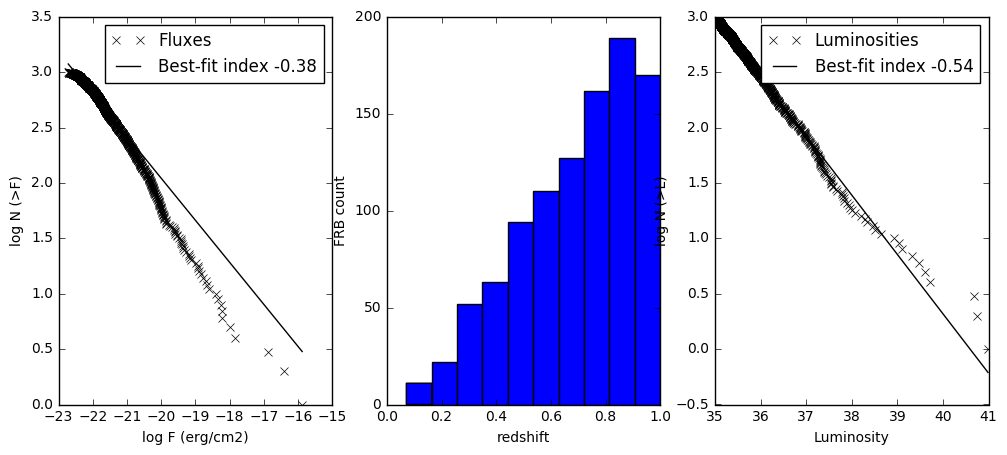

In [389]:
# fit and plot distribution

cnt2 = np.arange(1,len(fluxes)+1)[::-1]
popt2, pcov2 = curve_fit(plaw, fluxes, cnt2, p0=(-1, 1e-3))
print('Selected flux slope {0} and amplitude {1} (at F={2})'.format(popt2[0], popt2[1], fluxes[0]))

cnt3 = np.arange(1,len(lums)+1)[::-1]
popt3, pcov3 = curve_fit(plaw, lums, cnt3, p0=(-1, 1e-3))
print('Selected luminosity slope {0} and amplitude {1} (at L={2})'.format(popt3[0], popt3[1], lums[0]))

pl.figure(figsize=(12,5))
pl.subplot(131)
pl.plot(np.log10(fluxes), np.log10(cnt2), 'kx', label='Fluxes')
pl.plot(np.log10(fluxes), np.log10(plaw(fluxes, *popt2)), '-k', label='Best-fit index {0:.2f}'.format(popt2[0]))
pl.xlabel('log F (erg/cm2)')
pl.ylabel('log N (>F)')
pl.legend()
pl.subplot(132)
pl.hist(zs)
pl.xlabel('redshift')
pl.ylabel('FRB count')
pl.subplot(133)
pl.plot(np.log10(lums), np.log10(cnt3), 'kx', label='Luminosities')
pl.plot(np.log10(lums), np.log10(plaw(lums, *popt3)), '-k', label='Best-fit index {0:.2f}'.format(popt3[0]))
pl.xlabel('Luminosity')
pl.ylabel('log N (>L)')
pl.legend()